# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define

In [121]:
def guess_square_error(input_answers, input_weights = None):
    answers = np.array(input_answers, dtype = "float64") # formate float64
    rowwise_mean = np.average(answers, axis = 0)
    answers -= rowwise_mean
    square_ans = answers * answers
    if input_weights != None:
        for w in range(len(input_weights)):
            square_ans[w] *= input_weights[w]
    
    return square_ans.sum()

class SingleEntryMatrix():
    def __init__(self, size):
        self.elements = np.zeros(size + size, dtype = bool)
        for i in range(size[0]):
            for j in range(size[1]):
                self.elements[i][j][i][j] = True

class VariableArray():
    def __init__(self, size, mean = 0., std = 1., work_components = 1., is_independent_learning = False):
        self.size = size
        self.values = np.random.normal(mean, std, size)
        self.diff = np.zeros(size)
        self.drop = np.ones(size, dtype = bool)
        if work_components == 1:
            self.work = np.ones(size, dtype = bool)
        else:
            self.work = (np.random.random(size) < work_components)
        
        self.values *= self.work
        
        if is_independent_learning:
            self.eta_m = np.zeros(size)
        else:
            self.eta_m = None
    
    def move(self, eta = None):
        if eta == None:
            self.values -= self.eta_m * self.diff * self.work
        else:
            self.values -= eta * self.diff * self.work
    
    def zerodiff(self):
        self.diff *= 0.
    
    def set_drop(self, rate):
        self.drop = (np.random.random(size) < rate)

class Sigmoid():
    def set_dim(self, domain_dim):
        self.dd = domain_dim # domain dimension
        self.cd = domain_dim # codomain dimension
    
    def trans(self, x):
        return 1. / (1. + np.exp(-x))
    
    def diff(self, x):            
        return np.diag(1. / (np.exp(x) + np.exp(-x) + 2.))

class Identity():
    def set_dim(self, domain_dim):
        self.dd = domain_dim # domain dimension
        self.cd = domain_dim # codomain dimension
    
    def trans(self, x):
        return x
    
    def diff(self, x):
        return np.identity(self.dd)

class Layer():
    def __init__(self, layers_from, nodes_n, active_function):
        self.lf = layers_from # list :layers connected before
        self.lt = [] # layers connected to
        self.in_d = nodes_n
        self.weights = {}
        self.bias = VariableArray([self.in_d])
        self.backwards = {}
        self.af = active_function
        self.af.set_dim(self.in_d)
        self.out_d = self.af.cd
        self.nodes_input = np.zeros([self.in_d])
        self.output = np.zeros([self.out_d])
        self.af_diff = np.zeros([self.out_d, self.in_d])
    
    def forward(self):
        self.output = self.af.trans(self.nodes_input)
    
    def jacobi(self):
        self.af_diff = self.af.diff(self.nodes_input)

class DogikoNN():
    def __init__(self):
        self.pp_linear = {
            "multi" : None,
            "trans" : None
        } # pre-processing linear translation
        self.flow = []
        self.layers = {}
    
    def set_training_data(self, input_datas, input_answers, input_weights = None):
        # type input_data : numpy array
        # type input_answer : numpy array
        self.t_datas = input_datas
        self.t_answers = input_answers
        self.t_weights = input_weights
        self.single_data_size = self.t_datas.shape[1:]
        self.answer_size = self.t_answers.shape[1:]
        if self.t_weights == None:
            self.t_square_error = guess_square_error(self.t_answers)
        else:
            self.t_square_error = guess_square_error(self.t_answers, self.t_weights)
        
        if self.t_square_error == 0:
            self.t_square_error = 1
            print ("all training data has same result, can't normalize error")
    
    def set_validating_data(self, input_datas, input_answers, input_weights = None):
        # type input_data : numpy array
        # type input_answer : numpy array
        if input_datas.shape[1:] != self.single_data_size:
            print ("Size of datas should be the same as training data, must set_training_data before set_validating_data!")
        
        if input_answers.shape[1:] != self.answer_size:
            print ("Size of answers should be the same as training data, must set_training_data before set_validating_data!")
        
        self.v_datas = input_datas
        self.v_answers = input_answers
        self.v_weights = input_weights
        if self.v_weights == None:
            self.v_square_error = guess_square_error(self.v_answers)
        else:
            self.v_square_error = guess_square_error(self.v_answers, self.v_weights)
        
        if self.v_square_error == 0:
            self.v_square_error = 1
            print ("all validating data has same result, can't normalize error")
    
    def define_normalization(self, normalized_algorithm):
        self.normal_alg = normalized_algorithm
    
    def normalized(self, input_datas):
        return (input_datas - self.pp_linear["trans"]) * self.pp_linear["multi"]
    
    def layers_clear(self):
        self.layers = {}
        
    def insert_layer(self, name, layer, is_flow_add = True):
        self.layers[name] = layer
        if is_flow_add:
            self.flow.append(name)
        
    def build(self):
        if self.normal_alg == "normal":            
            self.pp_linear["trans"] = np.average(self.t_datas, axis=0)
            
            temp_std = np.std(self.t_datas, axis=0)
            temp_std[temp_std == 0] = 1
            self.pp_linear["multi"] = 1 / temp_std
        else:
            print ("unacceptable normalized_algorithm")
            return ("unacceptable normalized_algorithm")
        
        self.n_t_datas = self.normalized(self.t_datas)
        self.n_v_datas = self.normalized(self.v_datas)
        if len(self.flow) != len(set(self.flow)):
            print ("each element in .flow should be unique (layer name)")
            return ("each element in .flow should be unique (layer name)")
        
        self.single_entry_matrix = {}
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].lt = []
            for lnf in self.layers[ln].lf:
                if lnf == "input source":
                    self.layers[ln].weights[lnf] = VariableArray((self.layers[ln].in_d, ) + self.single_data_size)
                    self.layers[ln].backwards[lnf] = np.zeros(self.single_data_size)
                elif lnf not in self.layers:
                    print ("layer " + lnf + " doesn't exist!")
                else:
                    if self.flow.index(lnf) > l:
                        print ("layer " + lnf + " shoud work before layer " + ln)
                        return ("layer " + lnf + " shoud work before layer " + ln)
                    
                    self.layers[lnf].lt.append(ln)
                    self.layers[ln].weights[lnf] = VariableArray((self.layers[ln].in_d, self.layers[lnf].out_d,))
                    self.layers[ln].backwards[lnf] = np.zeros((self.layers[lnf].out_d))
                
                self.single_entry_matrix[self.layers[ln].weights[lnf].size] = SingleEntryMatrix(self.layers[ln].weights[lnf].size)
        
        self.layers[self.flow[-1]].lt.append("output result")
        
        if self.layers[self.flow[-1]].out_d != self.answer_size[0]:
            print ("out put size of final layer should be the same with answer size")
            return ("out put size of final layer should be the same with answer size")
    
    def t_cost_greadient(self, predict, answer):
        return (predict - answer) / self.t_square_error
    
    def forward_propagation(self, input_array):
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].nodes_input *= 0.
            for lnf in self.layers[ln].lf:
                if lnf == "input source":
                    self.layers[ln].nodes_input += self.layers[ln].weights[lnf].values.dot(input_array)
                else:
                    self.layers[ln].nodes_input += self.layers[ln].weights[lnf].values.dot(self.layers[lnf].output)
            
            self.layers[ln].nodes_input += self.layers[ln].bias.values
            self.layers[ln].forward()
            self.layers[ln].jacobi()
            
        return self.layers[self.flow[-1]].output
    
    def prediction(self, input_data):
        temp_data = self.normalized(input_data)
        output = np.zeros(input_data.shape[:1] + self.answer_size)
        for d in range(input_data.shape[0]):
            output[d] = self.forward_propagation(temp_data[d])
        
        return output
    
    def backward_propagation(self, data, answer, predict, cost_gradient, weight = None):     
        if weight == None:
            weight = 1.
        
        for l in range(len(self.flow) - 1, -1, -1):
            ln = self.flow[l]
            temp_array = np.zeros((self.layers[ln].out_d))
            for lnt in self.layers[ln].lt:
                if lnt == "output result":
                    temp_array += cost_gradient(predict, answer)
                else:
                    temp_array += self.layers[lnt].backward[ln]
            
            temp_array = temp_array.dot(self.layers[ln].af_diff)
            self.layers[ln].bias.diff += weight * temp_array
            for lnf in self.layers[ln].lf:
                for i in range(self.layers[ln].weights[lnf].size[0]):
                    for j in range(self.layers[ln].weights[lnf].size[1]):
                        if self.layers[ln].weights[lnf].work[i][j] and self.layers[ln].weights[lnf].drop[i][j]:
                            if lnf == "input source":
                                self.layers[ln].weights[lnf].diff[i][j] += weight * temp_array.dot(
                                    self.single_entry_matrix[self.layers[ln].weights[lnf].size].elements[i][j].dot(data)
                                )
                            else:
                                self.layers[ln].weights[lnf].diff[i][j] += weight * temp_array.dot(
                                    self.single_entry_matrix[self.layers[ln].weights[lnf].size].elements[i][j].dot(self.layers[lnf].output)
                                )
                
                self.layers[ln].backwards[lnf] = temp_array.dot(self.layers[ln].weights[lnf].values)
    
    def var_zerodiff(self):
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].bias.zerodiff()
            for lnf in self.layers[ln].lf:
                self.layers[ln].weights[lnf].zerodiff()
    
    def var_move(self, eta):
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].bias.move(eta)
            for lnf in self.layers[ln].lf:
                self.layers[ln].weights[lnf].move(eta)
    
    def var_set_drop(self, rate):
        for l in range(len(self.flow)):
            ln = self.flow[l]
            self.layers[ln].bias.set_drop(rate)
            for lnf in self.layers[ln].lf:
                self.layers[ln].weights[lnf].set_drop(rate)
    
    def single_batch(self, batch_datas, batch_answers, batch_weights = None, eta = None, g_change = None):
        self.var_zerodiff()
        batch_prediction = self.prediction(batch_datas)
        if batch_weights == None:
            for d in range(len(batch_datas)):
                self.backward_propagation(batch_datas[d], batch_answers[d], batch_prediction[d], self.t_cost_greadient, weight = None)
        else:
            for d in range(len(batch_datas)):
                self.backward_propagation(batch_datas[d], batch_answers[d], batch_prediction[d], self.t_cost_greadient, weight = batch_weights[d])
        
        self.var_move(eta)
    
    def single_epoch(self, batch_size, batchs_n = None, eta = None,  g_change = None, shuffle = False):
        batchs_allowed = int(len(self.n_t_datas) / batch_size)
        if batchs_allowed == 0:
            print("batch size should smaller than testing data amount")
            return "batch size should smaller than testing data amount"
        
        if batchs_n == None:
            batchs_n = batchs_allowed
        
        if shuffle:
            pass
        else:
            for b in range(min(batchs_allowed, batchs_n)):
                batch_datas = self.n_t_datas[b * batch_size:(b+1) * batch_size]
                batch_answers = self.t_answers[b * batch_size:(b+1) * batch_size]
                if self.t_weights != None:
                    batch_weights = self.t_weights[b * batch_size:(b+1) * batch_size]
                else:
                    batch_weights = None
                
                self.single_batch(batch_datas, batch_answers, batch_weights, eta = eta, g_change = g_change)
    
    def validating_error(self):
        temp_prediction = self.prediction(self.v_datas)
        temp_diff = temp_prediction - self.v_answers
        temp_sqr = temp_diff*temp_diff
        if self.v_weights != None:
            for d in range(temp_sqr.shape[0]):
                temp_sqr[d] *= self.v_weights[d]
        
        output = temp_sqr.sum()/self.v_square_error
        return output

# Test

In [82]:
test_NN =DogikoNN()
feature = np.array([[0.],[2.]])
result = np.array([[2.],[0.]])

test_NN.set_training_data(feature, result)
test_NN.set_validating_data(feature, result)

test_NN.define_normalization("normal")
test_NN.insert_layer(
    "A",
    Layer(
        layers_from=["input source"],
        nodes_n=1,
        active_function=Identity()
    )
)

test_NN.build()

In [111]:
test_NN.layers["A"].weights["input source"].values

array([[ 0.95542461]])

In [112]:
test_NN.layers["A"].bias.values

array([ 1.95542461])

In [113]:
test_NN.prediction(feature)

array([[ 1.        ],
       [ 2.91084923]])

In [117]:
test_NN.single_batch(batch_datas=np.array([[0.], [2.]]), batch_answers=np.array([[2.], [0.]]), eta=1)

cost_greadient =  [ 2.]  -  [ 2.] /  2.0
cost_greadient =  [ 0.]  -  [ 0.] /  2.0


In [94]:
test_NN.layers["A"].weights["input source"].diff

array([[ 0.]])

In [93]:
test_NN.layers["A"].bias.diff

array([-0.74993998])

In [120]:
test_NN.validating_error()

0.0

# example
Use 1 layer linear model predict sin-wave superposition with some noise

In [365]:
lms_NN = DogikoNN()

pre_d = np.zeros([400])
for i in range(400):
    pre_d[i] = np.sin(np.pi * i /50) + 0*np.sin(np.pi * i /33)

pre_d += (0. * np.random.rand(400) - 0.05)

try_data = np.zeros([398, 2])
try_answer = np.zeros([398, 1])
for i in range(398):
    try_data[i] = pre_d[i:i+2]
    try_answer[i] = pre_d[i+2:i+3]

lms_NN.set_training_data(try_data, try_answer)
lms_NN.set_validating_data(try_data, try_answer)

lms_NN.define_normalization("normal")

lms_NN.insert_layer(
    'A',
    Layer(
        layers_from = ["input source"],
        nodes_n = 1,
        active_function = Identity()
    )
)

lms_NN.build()


In [364]:
lms_NN.layers["A"].weights["input source"].values

array([[ -3.46120018e+74,   3.46133693e+74]])

In [363]:
lms_NN.layers["A"].weights["input source"].diff

array([[ -1.89938628e+72,   1.89946133e+72]])

In [362]:
lms_NN.single_epoch(398, eta = 0.1)
lms_NN.validating_error()

9.3160484487309558e+146

In [269]:
lms_NN.var_zerodiff()

In [368]:
lms_NN.v_square_error

199.99604744450312

In [361]:
for t in range(1000):
    lms_NN.single_epoch(398, eta = 0.1)
    if (t+1) % 100 == 0:
        print(t + 1, lms_NN.validating_error())

100 2.50366875512e+147
200 2.2434934282e+147
300 2.01035490503e+147
400 1.80144358497e+147
500 1.61424183448e+147
600 1.44649364649e+147
700 1.29617745288e+147
800 1.16148176207e+147
900 1.04078332841e+147
1000 9.32627590098e+146


In [247]:
predict_data = np.zeros([398,2])
for i in range(398):
    predict_data[i] = pre_d[i:i + 2]

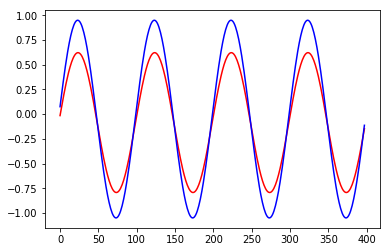

In [248]:
ans = lms_NN.prediction(predict_data)
plt.plot(ans.reshape(398), "-r", pre_d[2:], "-b")
plt.show()

# example 2
## weight test

random 0, 1 answer on $[-2, 2]$

set weight = 0 on $[-2, 2]$

compare weighted and non-weighted model

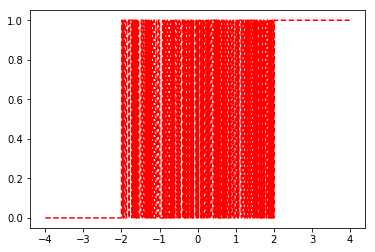

In [258]:
data = ((np.arange(800) - 400)/100).reshape(800,1)
answer = np.zeros((800,1)) + (data > 2.) + ((abs(data) < 2.) * np.random.randint(0,2, (800,1)))
weight = np.zeros((800)) + (abs(data.reshape(800)) > 2.)


plt.plot(data.reshape(800), answer.reshape(800), "--r")
plt.show()

In [259]:
model = DogikoNN()
w_model = DogikoNN()

model.set_training_data(data, answer)
model.set_validating_data(data, answer)
model.define_normalization("normal")
model.insert_layer(
    "A",
    Layer(
        layers_from=["input source"],
        nodes_n=1,
        active_function=Sigmoid()
    )
)

model.build()

w_model.set_training_data(data, answer, weight)
w_model.set_validating_data(data, answer, weight)
w_model.define_normalization("normal")
w_model.insert_layer(
    "A",
    Layer(
        layers_from=["input source"],
        nodes_n=1,
        active_function=Sigmoid()
    )
)
w_model.build()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:109: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:130: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


10 0.666538746909
20 0.689869996396
30 0.703161161401
40 0.711866208166
50 0.718048826533
60 0.722676013818
70 0.726267537957
80 0.72913054104
90 0.731459546809
100 0.733384450967


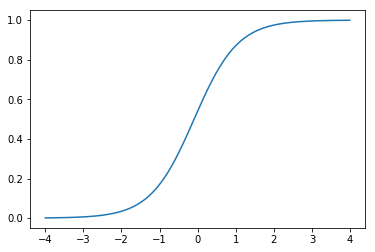

In [260]:
for t in range(100):
    model.single_epoch(800, eta = 1)
    if (t+1) % 10 == 0:
        print(t + 1, model.validating_error())

plt.plot(data, model.prediction(data))
plt.show()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:301: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:277: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:312: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


10 0.00142955031016
20 0.000366159123865
30 0.000178951840063
40 0.00010996335328
50 7.60396072817e-05
60 5.65125819618e-05
70 4.40918172036e-05
80 3.56254327161e-05
90 2.9553855193e-05
100 2.50270284427e-05


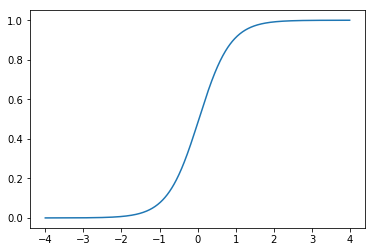

In [261]:
for t in range(100):
    w_model.single_epoch(800, eta = 1)
    if (t+1) % 10 == 0:
        print(t + 1, w_model.validating_error())

plt.plot(data, w_model.prediction(data))
plt.show()

In [8]:
test_NN =DogikoNN()
feature = np.array([[0.],[2.]])
result = np.array([[2.],[0.]])

test_NN.set_training_data(feature, result)
test_NN.set_validating_data(feature, result)

test_NN.define_normalization("normal")
test_NN.insert_layer(
    "A",
    Layer(
        layers_from=["input source"],
        nodes_n=1,
        active_function=Identity()
    )
)

In [9]:
test_NN.build()

In [32]:
test_NN.prediction(test_NN.v_datas)

array([[ 1.33289363],
       [-0.50006931]])

In [31]:
test_NN.validating_error()

0.34755011687672588

In [30]:
test_NN.single_epoch(2,eta=0.1)

In [63]:
test_NN.layers["A"].weights["input source"].values

array([[-0.93780609]])

In [64]:
test_NN.layers["A"].bias.values

array([ 1.00091364])